# Assignment 2: Problem 4

_STATS215: Statistical Models in Biology &middot; Stanford University &middot; Winter 2020_

**Due: February 14, 2020, 11:59pm PT**

**Name**:  Libby Zhang

**E-mail**:  eyz@stanford.edu

# Background

[Connectomics](https://en.wikipedia.org/wiki/Connectomics) is an exciting field that is generating enormous amounts of information about how neurons in the brain are wired to one another.  For example, the HHMI Janelia Research Campus and Google recently released an amazing map of connectivity in the fly brain.  See [their press release](https://www.janelia.org/news/unveiling-the-biggest-and-most-detailed-map-of-the-fly-brain-yet) for more information.  

We will set our sights on a smaller dataset: the connectome of _C. elegans_, a small worm, and the first organism to have a fully mapped connectome.  Recently, [Cook et al (2018)](https://www.nature.com/articles/s41586-019-1352-7) released an updated version of this synaptic connecivity.  The data is available at [https://wormwiring.org](https://wormwiring.org/).

Let's put the Poisson matrix factorization model (PMF) to use on some neural connectivity data.  You will implement the variational inference algorithm derived in Problem 3 and use it to find latent factors of variation in the connectivity between the ~300 neurons in the hermaphrodite _C. elegans_ nervous system.  

# Instructions
Complete the code cells that say ```# <<<Your code here>>>``` and run the notebook.  Once complete, print a .pdf version of the notebook and save the .ipynb file.  Submit both along with your written assignment on Canvas.

# References
Cook, S. J., Jarrell, T. A., Brittin, C. A., Wang, Y., Bloniarz, A. E., Yakovlev, M. A., ... & Bülow, H. E. (2019). Whole-animal connectomes of both Caenorhabditis elegans sexes. Nature, 571(7763), 63-71.



In [ ]:
import os
import copy
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import digamma, logsumexp
import pandas as pd
from tqdm.auto import tqdm, trange

# Download the data

In [48]:
# Download the edge list 
if not os.path.exists("herm_full_edgelist.csv"):
    !wget https://wormwiring.org/series/data/herm_full/herm_full_edgelist.csv
    
# Read in the connectivity data, given as a list of synapses
data = pd.read_csv("herm_full_edgelist.csv", 
                   names=["pre", "post", "weight", "type"],
                   header=0)

# Neurons start with capital letters.  There should be 302 total, but this 
# heuristic filter leaves us with 300.  That's close enough for our purposes.
neurons = filter(lambda name: name[0].isupper(), np.unique(data["pre"]))
neurons = [name.strip() for name in neurons]
neurons = np.array(list(neurons))
num_neurons = len(neurons)
print("Found {} neurons in the data.".format(num_neurons))

# Construct the weighted chemical adjacency matrix
W = np.zeros((num_neurons, num_neurons), dtype=int)
for idx, row in data.iterrows():
    i = np.where(neurons == row["pre"].strip())[0]
    j = np.where(neurons == row["post"].strip())[0]
    if row["type"] == "chemical":
        # These are directed connections
        W[i, j] = int(row["weight"])
    else:
        # Note that there are also undirected electrical synapses 
        # (i.e. gap junctions), and synapses between neurons and muscle cells.  
        # We will not consider them here.
        pass

# Download information about neuron types from wormatlas.
if not os.path.exists("NeuronType.xls"):
    !wget https://www.wormatlas.org/images/NeuronType.xls
type_data = pd.read_excel("NeuronType.xls")

# Extract the neuron ganglion designation and use it as a proxy for cell type.
neuron_types = []
for name in neurons:
    match = type_data[type_data["Neuron"] == name]
    if len(match) > 0:
        neuron_types.append(match.iloc[0][" AY Ganglion Designation"])
    else:
        neuron_types.append("UNK")
neuron_types = np.array(neuron_types)

# Permute cells by type
perm = np.argsort(neuron_types)
neuron_types = neuron_types[perm]
neurons = neurons[perm]
W = W[np.ix_(perm, perm)]

# Find boundaries between groups
bounds = np.where(neuron_types[1:] != neuron_types[:-1])[0] + 1
midpoints = (np.concatenate(([0], bounds)) + np.concatenate((bounds, [num_neurons]))) / 2
type_names = np.unique(neuron_types)

Found 300 neurons in the data.


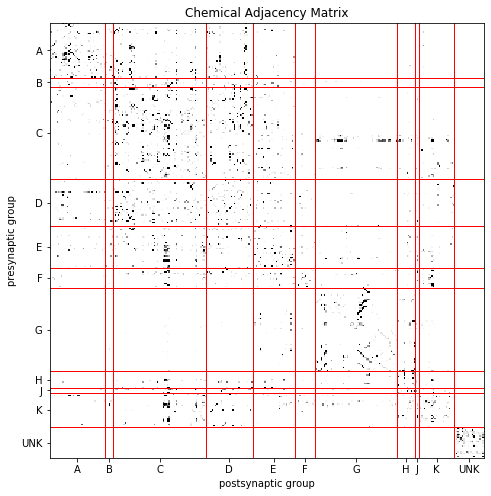

In [49]:
def plot_adjacency_matrix(W, ax=None, vmax=10, cmap="Greys"):
    # Plot the weighted adjacency matrix.
    # Truncate the weights at 10 to highlight
    # lower weight synapses.
    if ax is not None:
        plt.sca(ax)
    else:
        plt.figure(figsize=(8, 8))

    plt.imshow(W, cmap=cmap, vmax=vmax)
    for b in bounds:
        plt.plot([0, num_neurons], [b, b], '-r', lw=1)
        plt.plot([b, b], [0, num_neurons], '-r', lw=1)

    plt.xticks(midpoints, type_names)
    plt.yticks(midpoints, type_names)
    plt.xlim(0, num_neurons)
    plt.ylim(num_neurons, 0)
    plt.ylabel("presynaptic group")
    plt.xlabel("postsynaptic group")
    plt.title("Chemical Adjacency Matrix")

plot_adjacency_matrix(W)

# Find the indices with spikes. Make sure you understand these arrays because you will need them for the updates!

In [50]:
# The adjacency matrix is super sparse.  
# Pull out just the indicies of the non-zero entries (i.e. the synapses).
i_vals, j_vals = np.where(W)
y_vals = W[i_vals, j_vals]
num_synapses = len(y_vals)
print("Found {} synapses".format(num_synapses))
print('y_vals has shape: ', y_vals.shape)
print('W original shape: ', W.shape)
print(i_vals)

Found 3638 synapses
y_vals has shape:  (3638,)
W original shape:  (300, 300)
[  0   0   0 ... 299 299 299]


# Implement the mean field variational inference algorithm for the PMF model 

In problem 3 you derived the mean field coordinate ascent updates for the Poisson matrix factorization algorithm.  There were three types of variational factors,

$$
\begin{align*}
  q(\bar{y}_{mn}) &= \mathrm{Mult}(\pi_{mn}) 
   &\text{for } \{(m,n)\!: y_{mn} > 0\}, \\
  q(u_{mk}) &= \mathrm{Gamma}(a_{mk}, b_{mk}) 
  & \text{for } m=1, \ldots, N \text{ and } k = 1, \ldots, K,\\
  q(v_{nk}) &= \mathrm{Gamma}(a_{nk}, b_{nk})
  & \text{for } n=1, \ldots, N \text{ and } k = 1, \ldots, K,\\
\end{align*}
$$
where $K$ is a hyperparameter specifying the number of components.

In practice, the algorithm proceeds by updating the parameters associated with these distributions one at a time, holding the others fixed.  

# Initialization
This block of code initializes hyperparameters and defines some helper functions for initialization and computing expectations.


In [ ]:
# Specify the hyperparameters
alpha0 = 1.0
beta0 = 1.0
hypers = dict(alpha0=alpha0, beta0=beta0)

def initialize_variational_params(K):
    """
    Initialize the parameters of the variational inference algorithm.
    Use random initializations to break symmetries that could otherwise
    lead to poor local optima.
    """
    # Parameters of q(\bar{y})
    pi = npr.dirichlet(np.ones(K), size=(num_synapses,))
    # Parameters of q(u)
    a_u = 10 * npr.rand(num_neurons, K)
    b_u = np.ones((num_neurons, K))
    # Parameters of q(u)
    a_v = 10 * npr.rand(num_neurons, K)
    b_v = np.ones((num_neurons, K))
    return dict(pi=pi, a_u=a_u, b_u=b_u, a_v=a_v, b_v=b_v)


def multinomial_expectations(y, pi):
    """
    Helper function to compute E[x] where x ~ Mult(y, pi).
    Assume y.shape == (N,) and pi.shape == (N, K)
    """
    return y[:, None] * pi

def gamma_expectations(a, b):
    """
    Helper function to compute E[x] and E[log x] for x ~ Ga(a, b).
    """
    return a / b, digamma(a) - np.log(b)

# Implementation 
This is skeleton code for running mean field VI. Implement the updates where it says ```<<< Your code here >>>```.

In [ ]:
def run_mean_field_vi(num_factors, hypers, num_iters=300, print_intvl=10):
    """
    Run the mean field variational inference algorithm to approximate
    the posterior of a Poisson matrix factorization model with K factors.
    """
    def _update_q_ybar(params):
        """
        Update pi based on the expected sufficient statistics of q(u) and q(v).
        """
        E_u, E_logu = gamma_expectations(params["a_u"], params["b_u"])
        E_v, E_logv = gamma_expectations(params["a_v"], params["b_v"])

        NUM_NEURONS, NUM_FACTORS = E_u.shape
        NUM_SYNAPSES = i_vals.shape[0]
        # print('In q(ybar) update:')
        # print('E_u shape: %s, E_v shape: %s' %(E_u.shape, E_v.shape))

        # <<< Your code here >>>
        # We expect log_pi.shape = (3638,10) = (NUM_SYNAPSES x NUM_FACTORS)
        # E_u and E_v each have size (300,10) = (NUM_NEURONS x NUM_FACTORS)
        log_pi = np.zeros((NUM_SYNAPSES, NUM_FACTORS))

        for k in range(NUM_FACTORS):
          for s_idx, (i, j) in enumerate(zip(i_vals, j_vals)):
            log_pi[s_idx,k] = E_logu[i,k] + E_logv[j,k]

        #log_pi = temp[i_vals, j_vals]
        # print('log_pi.shape: %s' %(log_pi.shape,))
        pi = np.exp(log_pi - logsumexp(log_pi, axis=1, keepdims=True))
        return pi 

    def _update_q_u(params):
        """
        Update a_u and b_u based on the expected sufficient statistics 
        of q(ybar) and q(v).
        """
        E_ybar = multinomial_expectations(y_vals, params["pi"])
        E_v, E_logv = gamma_expectations(params["a_v"], params["b_v"])

        # print('In q(u) update:')
        # print('E_ybar shape: %s, E_v shape: %s' %(E_ybar.shape, E_v.shape))

        # Update the parameters
        a_u = np.zeros((num_neurons, num_factors))
        b_u = np.zeros((num_neurons, num_factors))
        
        for m in range(num_neurons): # For each presynaptic neuron m
            # <<< Your code here >>>

            # Find all the synapses where m was the presynaptic neuron
            s_idx = np.where(i_vals == m)[0]

            a_u[m] = hypers['alpha0'] + np.sum(E_ybar[s_idx], axis=0)
            b_u[m] = hypers['beta0']  + np.sum(E_v[j_vals[s_idx]],axis=0)
        return a_u, b_u

    def _update_q_v(params):
        """
        Update a_v and b_v based on the expected sufficient statistics 
        of q(ybar) and q(u).
        """
        E_ybar = multinomial_expectations(y_vals, params["pi"])
        E_u, E_logu = gamma_expectations(params["a_u"], params["b_u"])

        # Update the parameters
        a_v = np.zeros((num_neurons, num_factors))
        b_v = np.zeros((num_neurons, num_factors))
        for n in range(num_neurons): # For each post-synaptic neuron n
            # <<< Your code here >>>

            # Find all the synapses where n was the post-synaptic neuron
            s_idx = np.where(j_vals == n)[0]
            
            # Debug log: confirmed that a_v[n,k]'s are different from each other
            a_v[n] = hypers['alpha0'] + np.sum(E_ybar[s_idx], axis=0)
            b_v[n] = hypers['beta0']  + np.sum(E_u[i_vals[s_idx]],axis=0)
        return a_v, b_v

    # Initialize the epectations
    params = initialize_variational_params(num_factors)

    # Run the mean field coordinate ascent algorithm
    for itr in trange(num_iters):
        # Save the old parameters
        old_params = copy.deepcopy(params)

        # Update the parameters
        params["pi"] = _update_q_ybar(params)
        params["a_u"], params["b_u"] = _update_q_u(params)
        params["a_v"], params["b_v"] = _update_q_v(params)

        # Check parameter convergence in l2
        dparams = dict()
        for k in old_params.keys():
            dparams[k] = np.mean((params[k] - old_params[k])**2)
        
        if itr % print_intvl == 0:
            progress = "Iter {}: ".format(itr)
            for k, v in dparams.items():
                progress += "d{} : {:.3f}\t".format(k, v)
            print(progress)

    return params

# Execution

In [93]:
# Run the mean field coordinate ascent algorithm
num_factors = 10
params = run_mean_field_vi(num_factors, hypers)

# Extract the posterior expectations with the fitted approx. posterior
E_u, _ = gamma_expectations(params["a_u"], params["b_u"])
E_v, _ = gamma_expectations(params["a_v"], params["b_v"])

# Use the posterior mean as our reconstruction
E_W = np.dot(E_u, E_v.T)

Iter 0: dpi : 0.017	da_u : 67.026	db_u : 5490.675	da_v : 132.307	db_v : 3.962	
Iter 10: dpi : 0.000	da_u : 0.537	db_u : 0.825	da_v : 0.867	db_v : 0.199	
Iter 20: dpi : 0.000	da_u : 0.126	db_u : 0.040	da_v : 0.273	db_v : 0.020	
Iter 30: dpi : 0.000	da_u : 0.061	db_u : 0.014	da_v : 0.122	db_v : 0.007	
Iter 40: dpi : 0.000	da_u : 0.048	db_u : 0.006	da_v : 0.121	db_v : 0.004	
Iter 50: dpi : 0.000	da_u : 0.021	db_u : 0.004	da_v : 0.079	db_v : 0.002	
Iter 60: dpi : 0.000	da_u : 0.009	db_u : 0.002	da_v : 0.039	db_v : 0.001	
Iter 70: dpi : 0.000	da_u : 0.008	db_u : 0.001	da_v : 0.022	db_v : 0.001	
Iter 80: dpi : 0.000	da_u : 0.006	db_u : 0.001	da_v : 0.015	db_v : 0.000	
Iter 90: dpi : 0.000	da_u : 0.006	db_u : 0.001	da_v : 0.013	db_v : 0.001	
Iter 100: dpi : 0.000	da_u : 0.004	db_u : 0.001	da_v : 0.008	db_v : 0.000	
Iter 110: dpi : 0.000	da_u : 0.003	db_u : 0.000	da_v : 0.007	db_v : 0.000	
Iter 120: dpi : 0.000	da_u : 0.002	db_u : 0.000	da_v : 0.006	db_v : 0.000	
Iter 130: dpi : 0.000	da_u : 0

# Analyze the results

Text(0.5, 1.0, 'Reconstructed Connectivity')

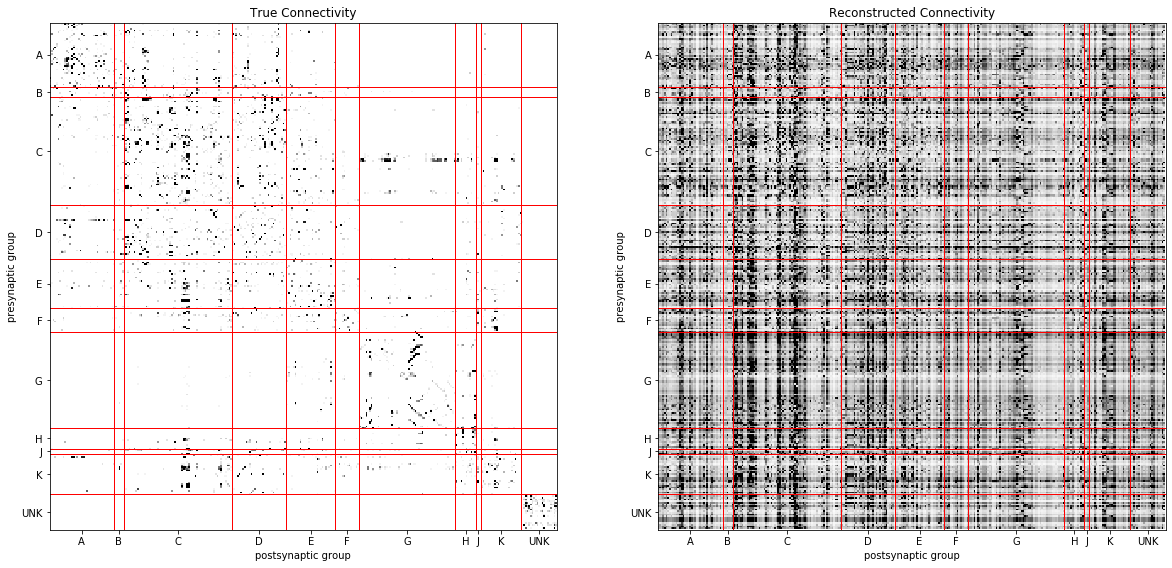

In [94]:
# Plot the true and reconstructed matrices. 
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plot_adjacency_matrix(W, ax=axs[0])
axs[0].set_title("True Connectivity")
plot_adjacency_matrix(E_W, ax=axs[1])
axs[1].set_title("Reconstructed Connectivity")

Text(0.5, 1.0, 'Postsynaptic Factors')

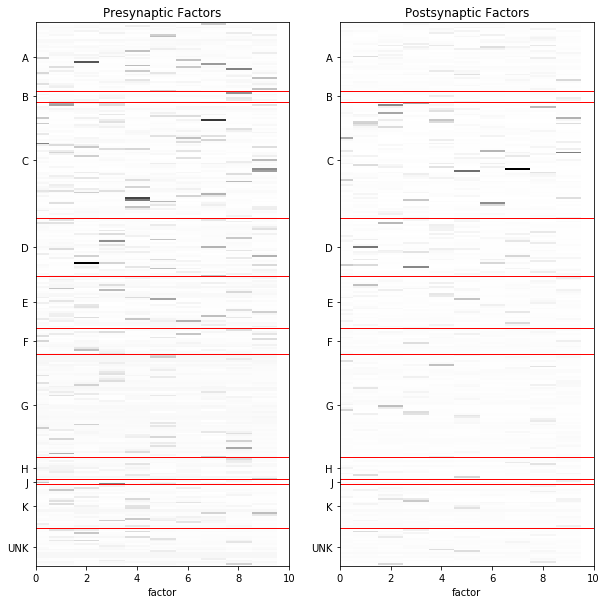

In [95]:
# Plot the neuron presynaptic (U) and postsynaptic (V) factors.
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(E_u, cmap="Greys", aspect="auto")
for b in bounds:
    axs[0].plot([0, num_factors], [b, b], '-r', lw=1)
axs[0].set_yticks(midpoints)
axs[0].set_yticklabels(type_names)
axs[0].set_ylim(num_neurons, 0)
axs[0].set_xlabel("factor")
axs[0].set_xlim(0, num_factors)
axs[0].set_title("Presynaptic Factors")

axs[1].imshow(E_v, cmap="Greys", aspect="auto")
for b in bounds:
    axs[1].plot([0, num_factors], [b, b], '-r', lw=1)
axs[1].set_yticks(midpoints)
axs[1].set_yticklabels(type_names)
axs[1].set_ylim(num_neurons, 0)
axs[1].set_xlabel("factor")
axs[1].set_xlim(0, num_factors)
axs[1].set_title("Postsynaptic Factors")

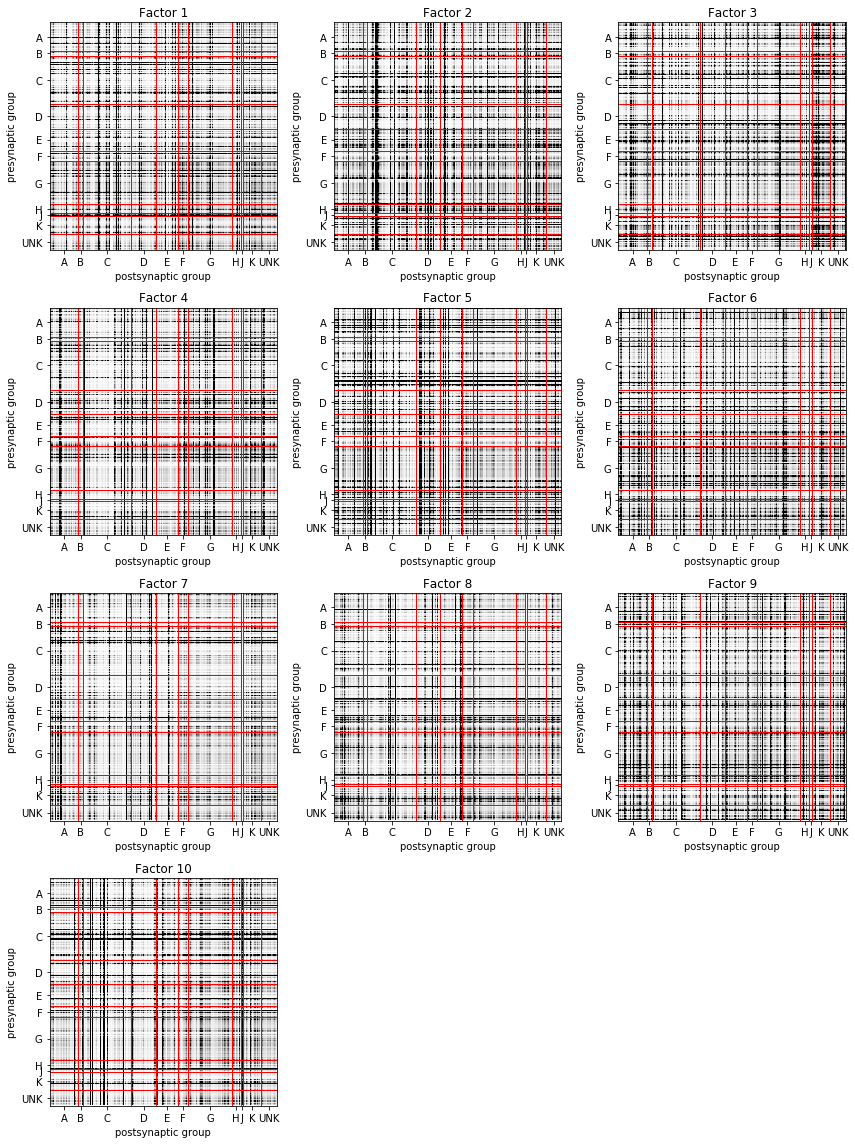

In [96]:
# Plot the additive contribution of each factor to the overall connectivity
ncols = 3
nrows = int(np.ceil(num_factors / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
for k in range(num_factors):
    row, col = k // ncols, k % ncols
    plot_adjacency_matrix(np.outer(E_u[:, k], E_v[:, k]), ax=axs[row, col], vmax=1)
    axs[row, col].set_title("Factor {}".format(k+1))

for k in range(num_factors, nrows * ncols):
    row, col = k // ncols, k % ncols
    axs[row, col].set_visible(False)

plt.tight_layout()